### TP4-1

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
* A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  move-se (i.e. derrapa); no modo `Stopped` o veículo está imobilizado.
* A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`   e a `velocidade linear das rodas`  ambas em relação so solo.
* Assume-se que o sistema de travagem exerce uma força de atrito proporcional à diferença das duas velocidades.  A dinâmica contínua, as equações de fluxo, está descrita  abaixo.
* Os “switchs” são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser  de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
* É imprescindível evitar que o sistema tenha “trajetórias de Zenão”. Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo  que tendem para zero mas nunca alcançam zero.

Faça 

1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
2. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
        i. "o veículo imobiliza-se completamente em menos de t segundos"; 
        ii. "a velocidade V diminui sempre com o tempo".
3. Codifique em SMT’s o modelo que definiu em 1.
4. Codifique em SMT’s a verificação das propriedades temporais que definiu em 2.

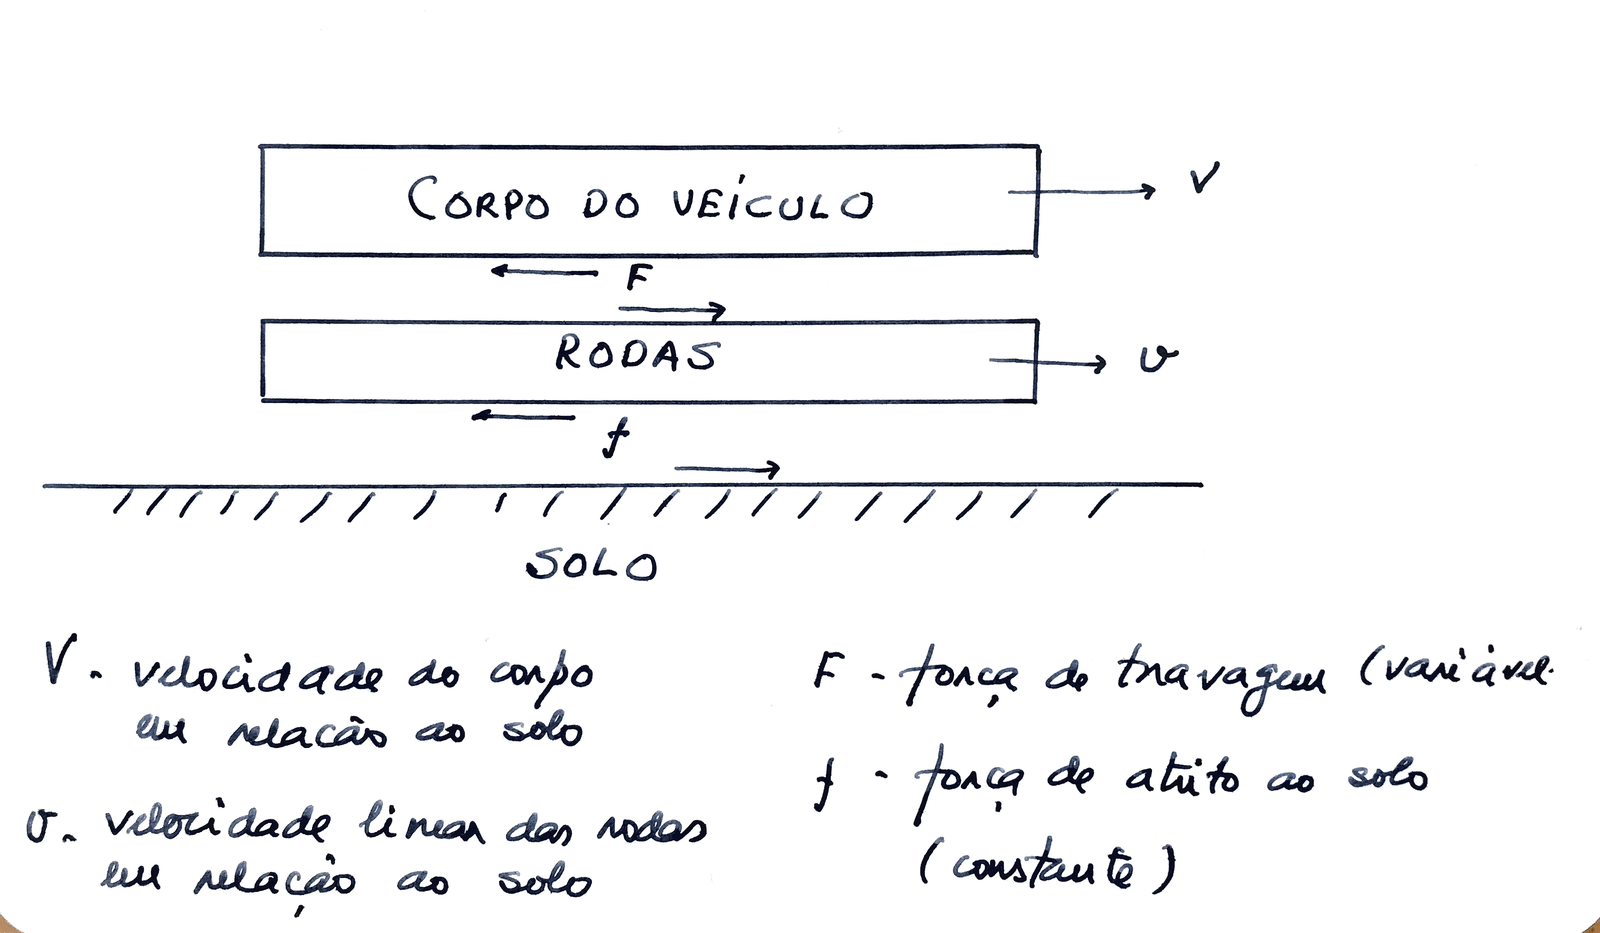

Equações de Fluxo 

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 
2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\, P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.
3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades $$F =  c\, (V-v)$$
      A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.

4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`, $$(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$$  
e , no modo `Blocked`,  a dinâmica do sistema é  regida por $$(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$$
6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$segundos.  Os     $\mathsf{switch}(V,v,t,V',v',t')\,$  nesses modos devem forçar esta condição. 
7. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.
8. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

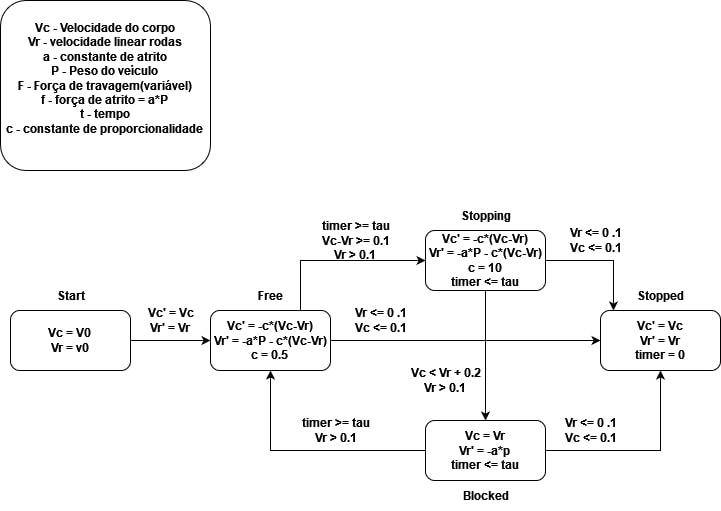

### Função declare(i):


In [1]:
from z3 import *  

Mode, (START,STOPPING,STOPPED,BLOCKED,FREE) = EnumSort('Mode', ('START','STOPPING','STOPPED','BLOCKED','FREE'))

def declare(i):
    state = {}
    state['m']  = Const('m'+str(i),Mode)
    state['Vr'] = Real('Vr'+str(i))
    state['Vc'] = Real('Vc'+str(i))
    state['t']  = Real('t' +str(i))
    state['timer'] = Real('timer'+str(i))
    return state

### Função init(s, v_init):


In [2]:
a, c, c_stopping, P, tau, intervalo = 0.001, 0.15, 1, 900, 0.1, 0.1
#a, c, c_stopping, P, tau, intervalo = 0.004, 0.1, 1.2, 900, 0.1, 0.1
def init(s, v_init):
    return And(
        s['t'] == 0,
        s['m'] == START,
        s['Vr'] == v_init,
        s['Vc'] == v_init,
        s['timer'] == 0
    )

### Função trans(s,p):
#### bla

In [3]:
def trans(s, p):
    start_free = And(
        s['t'] == p['t'], 
        s['Vr'] == p['Vr'],
        s['Vc'] == p['Vc'], 
        s['m'] == START, 
        p['m'] == FREE,
        s['timer'] == 0,
        p['timer'] == 0
    )
    
    free_free = And(
        s['m'] == FREE,
        p['m'] == FREE,
        p['Vc'] == s['Vc'] + (-c * (s['Vc'] - s['Vr'])),
        p['Vr'] == s['Vr'] + (-a*P + c*(s['Vc'] - s['Vr'])),
        p['t'] == s['t'] + intervalo,
        p['timer'] == s['timer'] + intervalo,
        p['timer'] <= tau,
        s['Vr'] > 0.1
    )
    
    
    free_stopping = And( 
        s['t'] == p['t'], 
        s['Vr'] == p['Vr'], 
        s['Vc'] == p['Vc'],
        s['m'] == FREE, 
        p['m'] == STOPPING,  
        p['timer']==0,
        s['Vr'] > 0.1,
        Or(
            s['timer']>=tau,
            s['Vc'] - s['Vr']>=0.1
        )
    )

    
    stopping_blocked = And(
        s['t'] == p['t'], 
        s['Vr'] == p['Vr'], 
        s['Vc'] == p['Vc'], 
        s['m'] == STOPPING, 
        p['m'] == BLOCKED, 
        s['Vc'] < s['Vr'] + 0.2,
        s['timer'] == 0,
        p['timer'] == 0,
        s['Vr'] > 0.1
    )
    
    stopping_stopping = And(
        s['m'] == STOPPING,
        p['m'] == STOPPING, 
        p['Vc'] == s['Vc'] +   (-c_stopping * (s['Vc'] - s['Vr'])), 
        p['Vr'] == s['Vr'] +   (-a * P + c_stopping * (s['Vc'] - s['Vr'])),
        s['Vc'] > s['Vr'] + 0.2,
        p['t'] == s['t']+intervalo,
        s['timer'] == p['timer'],
    )
    
    stopping_stopped = And( 
        s['t']  == p['t'],  
        s['m']  == STOPPING, 
        p['m']  == STOPPED, 
        s['Vc'] <= 0.1,
        s['Vr'] <= 0.1,
        p['Vc'] == 0,
        p['Vr'] == 0,
        p['timer'] == 0
    )
    
    blocked_free = And( 
        s['t'] == p['t'], 
        s['Vr'] == p['Vr'], 
        s['Vc'] == p['Vc'], 
        s['m'] == BLOCKED, 
        p['m'] == FREE, 
        s['timer']>=tau, 
        p['timer']==0,
        s['Vr'] > 0.1
    )
    
    blocked_blocked = And(
        s['m'] == BLOCKED,
        p['m'] == BLOCKED, 
        p['Vc'] == s['Vr'], 
        p['Vr']   == s['Vr'] + (-a*P), 
        p['t'] == s['t']+intervalo,
        p['timer']==s['timer']+intervalo,
        p['timer']<=tau,
    )
    
    blocked_stopped = And(  
        s['t'] == p['t'],  
        s['m'] == BLOCKED, 
        p['m'] == STOPPED,
        s['Vc'] <= 0.1,
        s['Vr'] <= 0.1,
        p['Vc'] == 0,
        p['Vr'] == 0,
        p['timer'] == 0
    )
    
    stopped_stopped = And(
        s['m'] == STOPPED, 
        p['m'] == STOPPED, 
        p['t'] == s['t']+intervalo,
        s['timer'] == 0,
        p['timer'] == 0,
        s['Vr'] == p['Vr'],
        s['Vc'] == p['Vc']
    )
    
    return Or(
        start_free,
        
        free_free,
        free_stopping,
        
        stopping_blocked,
        stopping_stopped,
        stopping_stopping,
        
        blocked_free,
        blocked_blocked,
        blocked_stopped,
        
        stopped_stopped
    )

### Função geraTraco

In [ ]:
def gera_traco(declare, init, trans, k):

    s = Solver()
    traco = [declare(i) for i in range(k)]

    s.add(init(traco[0], 20))
    
    for i in range(k-1):
        s.add(trans(traco[i], traco[i+1]))
            
    if s.check() == sat:
        m = s.model()
        
        for i in range(k):
            print("Estado:", i)
            for v in traco[i]:
                res = m[traco[i][v]]
                 
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
            print()
               
    else:
        print("Não tem solução.")
        
gera_traco(declare, init, trans, 120)